<a href="https://colab.research.google.com/github/jessica-zepeda/FinalProjectCSC308/blob/Jessica-changes/Copy_of_BUGS!_and_Cats_and_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Preparation

The first thing we need to do is get and prepare the data for which we’ll be training the CNN.

The data set we’ll use is a random subset of the data set from the Kaggle Dogs Versus Cats competition. You can download the data [here](https://kaggle.com/c/dogs-vs-cats/data).

Copy the downloaded dogs-vs-cats.zip file, and paste it into whichever directory you’d like to work from. Relative to the Jupyter notebook we'll be working in, I'm placing dogs-vs-cats.zip within a directory called data.

Now, extract dogs-vs-cats.zip, and then extract train.zip from within. We won't be working with the provided test set for the moment, so you can move the test1.zip elsewhere if you'd like.

Next, select all of the image files from within the train directory and move them into the base dogs-vs-cats directory. Lastly, delete the empty train directory.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using the script below, we'll organize our data into train, validation, and test sets. We'll do this by moving subsets of the data into sub-directories for each separate data set.

In [ ]:
train_path = '/content/drive/My Drive/Bugs dogs-vs-cats/train'
valid_path = '/content/drive/My Drive/Bugs dogs-vs-cats/valid'
test_path = '/content/drive/My Drive/Bugs dogs-vs-cats/test'

We can use Keras' ImageDataGenerator class to create batches of data from the directories we made.

Notice, to **ImageDataGenerator** for each of the data sets, we specify **preprocessing_function=tf.keras.applications.vgg16.preprocess_input**. For now, just understand this does an additional processing step on the images.

To **flow_from_directory()**, we first specify the path for the data, target_size of the images, which will resize all images to the specified size.

The **classes** parameter expects a list that contains the underlying class names, and lastly, we specify the batch_size.

We also specify **shuffle=False** only for test_batches. That's because, later when we plot the evaluation results from the model to a confusion matrix, we'll need to able to access the unshuffled labels for the test set. By default, the data sets are shuffled.

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['bee', 'wasp'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['bee', 'wasp'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=['bee', 'wasp'], batch_size=10, shuffle=False)

Found 601 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


##Visualizing The Data

In [ ]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py
/usr/local/lib/python3.7/dist-packages/PIL/Image.py


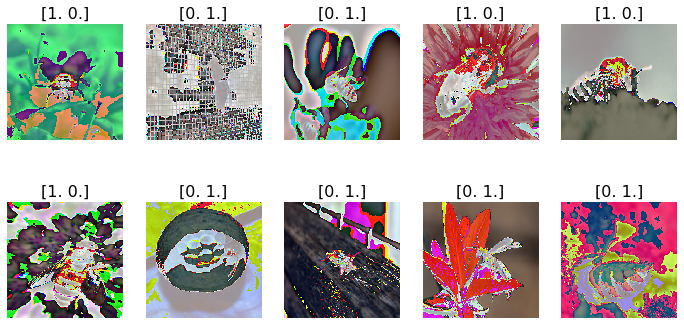

In [ ]:
import sys
from PIL import Image
sys.modules['Image'] = Image 
print(Image.__file__)
import Image
print(Image.__file__)

test_imgs, test_lables = next(train_batches)
plots(test_imgs, titles=test_lables, rows=2)

# Build And Train A Convolutional Neural Network With TensorFlow's Keras API

The pre-trained model we'll be working with to classify images of cats and dogs is called VGG16.

We’ll import this VGG16 model and then fine-tune it using Keras. The fine-tuned model will only work to classify images as either cats or dogs.

In [ ]:
#import vgg16 model
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We then iterate over each of the layers in vgg16_model, except for the last layer, and add each layer to the new Sequential model.

In [ ]:
#create a new model that will obtain the same layers as the vgg16 model

model = Sequential()
for i in range(0, len(vgg16_model.layers)-1):
    layer = vgg16_model.layers[i]
    model.add(layer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

Next, we’ll iterate over each of the layers in our new Sequential model and set them to be non-trainable. This freezes the weights and other trainable parameters in each layer so that they will not be trained or updated when we later pass in our images of cats and dogs.

In [ ]:
for layer in model.layers:
    layer.trainable = False 
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

##Training the CNN

We have to fit the model with our data.

We need to specify **steps_per_epoch** to indicate how many batches of samples from our training set should be passed to the model before declaring one epoch complete. 

In [ ]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.fit(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=4,epochs=30, verbose=2)

Epoch 1/30
4/4 - 41s - loss: 1.0411 - accuracy: 0.5250 - val_loss: 0.7922 - val_accuracy: 0.5750 - 41s/epoch - 10s/step
Epoch 2/30
4/4 - 39s - loss: 1.0009 - accuracy: 0.6000 - val_loss: 0.6059 - val_accuracy: 0.6250 - 39s/epoch - 10s/step
Epoch 3/30
4/4 - 38s - loss: 0.6990 - accuracy: 0.6750 - val_loss: 0.5242 - val_accuracy: 0.7000 - 38s/epoch - 9s/step
Epoch 4/30
4/4 - 38s - loss: 0.2667 - accuracy: 0.8750 - val_loss: 0.4781 - val_accuracy: 0.8000 - 38s/epoch - 9s/step
Epoch 5/30
4/4 - 37s - loss: 0.8158 - accuracy: 0.6750 - val_loss: 0.6011 - val_accuracy: 0.7500 - 37s/epoch - 9s/step
Epoch 6/30
4/4 - 37s - loss: 0.5637 - accuracy: 0.8000 - val_loss: 0.3849 - val_accuracy: 0.8500 - 37s/epoch - 9s/step
Epoch 7/30
4/4 - 36s - loss: 0.5417 - accuracy: 0.8000 - val_loss: 0.3772 - val_accuracy: 0.8750 - 36s/epoch - 9s/step
Epoch 8/30
4/4 - 37s - loss: 0.5093 - accuracy: 0.7750 - val_loss: 0.3725 - val_accuracy: 0.8750 - 37s/epoch - 9s/step
Epoch 9/30
4/4 - 37s - loss: 0.3637 - accuracy

#Predictions with Keras API

In [ ]:
#Extract a batch of images and labels from test set
test_imgs, test_labels = next(test_batches) 

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


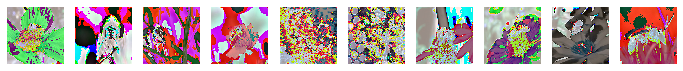

In [ ]:
plots(test_imgs)
print(test_labels)

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [ ]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [1., 1.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [1., 0.

##Plotting Predictions With a Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
test_batches.class_indices

{'bee': 0, 'wasp': 1}

Confusion matrix, without normalization
[[136  14]
 [ 23 127]]


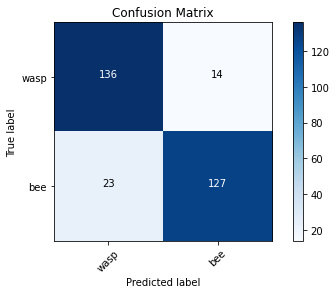

In [ ]:
cm_plot_labels = ['wasp','bee']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
print("Accuracy: %.1f%%" % (accuracy * 100))

Accuracy: 87.7%
